# 读取数据

In [42]:
import numpy as np
import json
import os
import pickle
from PIL import Image, ImageDraw ,ImageFont
import matplotlib.pyplot as plt
import h5py

In [43]:
# 控制数据类型
dataset_type = "train"

In [44]:
dataset = np.load('../data/imdb/textvqa_0.5/imdb_textvqa_{}.npy'.format(dataset_type), allow_pickle=True)

#### 读取图像的函数

In [45]:
def get_image(image_id):
    #image_dir = '/home/data/textvqa/' + ('train' if dataset == 'train' or dataset == 'val' else 'test') + '_images/'
    image_dir = '/home/data/textvqa/{}_images/'.format(dataset_type)
    image = Image.open(image_dir + image_id + '.jpg')
    
    return image

#### 画图像的函数

In [46]:
def draw_image(image_id):
    
    # 获取图像
    image = get_image(image_id)
    
    draw = ImageDraw.Draw(image)
#     for i in range(bb.shape[0]):
#         at1 = x_in_top(i,ind[:,0]) 
#         at2 = x_in_top(i,ind[:,1])
#         if at1 or at2:
#             color = get_color()
#         else:
#             continue
#         draw.rectangle((bb[i][0]*image.width,bb[i][1]*image.height,bb[i][2]*image.width,bb[i][3]*image.height), outline=color,width=3)
#     image.save(save_dir+str(index)+'_'+image_name)
    plt.figure(figsize = (10, 10))
    plt.imshow(image)

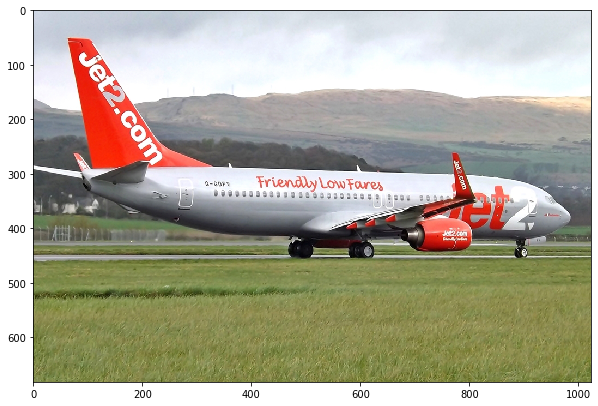

In [52]:
# test： 画一张图片
draw_image('02b2daa20b00f5d3')

In [63]:
image = get_image('02b2daa20b00f5d3')
top_left_x = 0.38788166642189
top_left_y = 0.43824326992035
height = 0.047748845070601
width = 0.24784621596336

x = int(image.width * top_left_x)
y = int(image.height * top_left_y)
h = int(image.height * height)
w = int(image.width * width)

region = (x, y, x + w, y + h)

cropImg = image.crop(region)
cropImg.save('mm.jpg')

In [51]:
dataset[15]

{'question': 'what does this jet advertise as having?',
 'image_id': '02b2daa20b00f5d3',
 'image_classes': ['Tree', 'Vehicle', 'Airplane', 'Aircraft'],
 'flickr_original_url': 'https://farm4.staticflickr.com/7403/13914609743_2004ef8b74_o.jpg',
 'flickr_300k_url': 'https://c3.staticflickr.com/8/7403/13914609743_23fdb967b3_z.jpg',
 'image_width': 1024,
 'image_height': 682,
 'answers': ['friendly low fares',
  'friendly low fares',
  'friendly low fares',
  'friendly low fares',
  'friendly low fares',
  'friendly low fares',
  'friendly low fares',
  'friendly low fairs',
  'friendly low fares',
  'friendly low fares'],
 'ocr_tokens': ['S',
  '"O',
  'G-GDFV',
  'FriendlyLowFares',
  'Fares',
  'S',
  '**..................',
  'aaමaB',
  ':',
  ':p.8',
  'Jei2.com'],
 'ocr_info': [{'word': 'S',
   'bounding_box': {'top_left_x': 0.064264327287674,
    'top_left_y': 0.10972630977631,
    'width': 0.16890430450439,
    'height': 0.30445569753647,
    'rotation': 0,
    'yaw': -5.9413371086

#### 把所有的图片保存成jpg格式

In [41]:
# import cv2 as cv
#  import matplotlib.image as mp
!ls /home/data/textvqa/

open_images.tar.gz  TextVQA_0.5_test.json   TextVQA_0.5_val.json
test_images	    TextVQA_0.5_train.json  train_images


In [ ]:
# 图片保存的路径
root_dir = "ocr_clean_data/images/{}".format(dataset_type)

# 如果不存在目录在进行保存
# 否则说明已经保存过了
if not os.path.exists(root_dir):
    os.makedirs(root_dir)
    for image_index in range(1, len(dataset)):
        # 图片对应的字典
        data_dict = dataset[image_index]
        # 获得image
        image = get_image(data_dict["image_id"])
        # 保存图片
        image_path = root_dir + "/{}_{}_{}.jpg".format(dataset_type, image_index, data_dict["image_id"])
        image.save(image_path)
        
        if (image_index % 100 == 0):
            print(image_index)
    print("success!")

#### 文本检测
   dataset：numpy.ndarray, 里面都是字典类型（每张图对应一个dict）

In [9]:
# for image_index in range(1, len(dataset)):
for image_index in range(1, 2):
    

SyntaxError: invalid syntax (<ipython-input-9-f1e43f7278ae>, line 1)

In [ ]:
# coding=utf-8
import os
import shutil
import sys
import time

import cv2
import numpy as np
import tensorflow as tf

sys.path.append(os.getcwd())
from nets import model_train as model
from utils.rpn_msr.proposal_layer import proposal_layer
from utils.text_connector.detectors import TextDetector

tf.app.flags.DEFINE_string('test_data_path', 'data/demo/', '')
tf.app.flags.DEFINE_string('output_path', 'data/res/', '')
tf.app.flags.DEFINE_string('gpu', '0', '')
tf.app.flags.DEFINE_string('checkpoint_path', 'checkpoints_mlt/', '')
FLAGS = tf.app.flags.FLAGS


def get_images():
    files = []
    exts = ['jpg', 'png', 'jpeg', 'JPG']
    for parent, dirnames, filenames in os.walk(FLAGS.test_data_path):
        for filename in filenames:
            for ext in exts:
                if filename.endswith(ext):
                    files.append(os.path.join(parent, filename))
                    break
    print('Find {} images'.format(len(files)))
    return files


def resize_image(img):
    img_size = img.shape
    im_size_min = np.min(img_size[0:2])
    im_size_max = np.max(img_size[0:2])

    im_scale = float(600) / float(im_size_min)
    if np.round(im_scale * im_size_max) > 1200:
        im_scale = float(1200) / float(im_size_max)
    new_h = int(img_size[0] * im_scale)
    new_w = int(img_size[1] * im_scale)

    new_h = new_h if new_h // 16 == 0 else (new_h // 16 + 1) * 16
    new_w = new_w if new_w // 16 == 0 else (new_w // 16 + 1) * 16

    re_im = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    return re_im, (new_h / img_size[0], new_w / img_size[1])


def main(argv=None):
    if os.path.exists(FLAGS.output_path):
        shutil.rmtree(FLAGS.output_path)
    os.makedirs(FLAGS.output_path)
    os.environ['CUDA_VISIBLE_DEVICES'] = FLAGS.gpu

    with tf.get_default_graph().as_default():
        input_image = tf.placeholder(tf.float32, shape=[None, None, None, 3], name='input_image')
        input_im_info = tf.placeholder(tf.float32, shape=[None, 3], name='input_im_info')

        global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)

        bbox_pred, cls_pred, cls_prob = model.model(input_image)

        variable_averages = tf.train.ExponentialMovingAverage(0.997, global_step)
        saver = tf.train.Saver(variable_averages.variables_to_restore())

        with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
            ckpt_state = tf.train.get_checkpoint_state(FLAGS.checkpoint_path)
            model_path = os.path.join(FLAGS.checkpoint_path, os.path.basename(ckpt_state.model_checkpoint_path))
            print('Restore from {}'.format(model_path))
            saver.restore(sess, model_path)

            im_fn_list = get_images()
            for im_fn in im_fn_list:
                print('===============')
                print(im_fn)
                start = time.time()
                try:
                    im = cv2.imread(im_fn)[:, :, ::-1]
                except:
                    print("Error reading image {}!".format(im_fn))
                    continue

                img, (rh, rw) = resize_image(im)
                h, w, c = img.shape
                im_info = np.array([h, w, c]).reshape([1, 3])
                bbox_pred_val, cls_prob_val = sess.run([bbox_pred, cls_prob],
                                                       feed_dict={input_image: [img],
                                                                  input_im_info: im_info})

                textsegs, _ = proposal_layer(cls_prob_val, bbox_pred_val, im_info)
                scores = textsegs[:, 0]
                textsegs = textsegs[:, 1:5]

                textdetector = TextDetector(DETECT_MODE='H')
                boxes = textdetector.detect(textsegs, scores[:, np.newaxis], img.shape[:2])
                boxes = np.array(boxes, dtype=np.int)

                cost_time = (time.time() - start)
                print("cost time: {:.2f}s".format(cost_time))

                for i, box in enumerate(boxes):
                    cv2.polylines(img, [box[:8].astype(np.int32).reshape((-1, 1, 2))], True, color=(0, 255, 0),
                                  thickness=2)
                img = cv2.resize(img, None, None, fx=1.0 / rh, fy=1.0 / rw, interpolation=cv2.INTER_LINEAR)
                cv2.imwrite(os.path.join(FLAGS.output_path, os.path.basename(im_fn)), img[:, :, ::-1])

                with open(os.path.join(FLAGS.output_path, os.path.splitext(os.path.basename(im_fn))[0]) + ".txt",
                          "w") as f:
                    for i, box in enumerate(boxes):
                        line = ",".join(str(box[k]) for k in range(8))
                        line += "," + str(scores[i]) + "\r\n"
                        f.writelines(line)


if __name__ == '__main__':
    tf.app.run()


#### 文字识别 aster